## Plot Results

In [2]:
import networkx as nx
import scipy.linalg as linalg
from sensors import utils, flows
import numpy as np
import pickle

In [2]:
def load_sensors(G, labeled_edges, filename):
    evaluator = flows.lazy.LazyEvaluator(G, labeled_edges)
    with open(filename, "rb") as f:
        evaluator.set_sensors(pickle.load(f))
    return evaluator

In [3]:
def load_results(prefix):
    with open("results/{}_flow_correlations.pkl".format(prefix), "rb") as f:
        results = pickle.load(f)
        
    return results

In [29]:
import matplotlib
import matplotlib.pyplot as plt

def plot_results(results, ax, title, xlabel=False, ylabel=False, legend=False):
#     ax.plot(results["greedy"].keys(), results["greedy"].values(), "b", label="Greedy",
#            linewidth=3)
    ax.plot(results["rrqr"].keys(), results["rrqr"].values(), "r", label="Weighted RRQR",
           linewidth=3)
    ax.plot(results["random"].keys(), results["random"].values(), "black", label="Random",
           linewidth=3, linestyle="dashed")
    ax.plot(results["max"].keys(), results["max"].values(), "m", label="Max Flow",
           linewidth=3, linestyle="dashed")
    
    if results["rb"]:
        ax.plot(results["rb"].keys(), results["rb"].values(), "g", label="RB",
           linewidth=3)
    
    if legend:
        ax.legend(fontsize=14)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    if xlabel:
        ax.set_xlabel("Number of Sensors (%)", fontsize=20)
    else:
        ax.set_xticklabels([])
    if ylabel:
        ax.set_ylabel("Correlation", fontsize=20)
    else:
        ax.set_yticklabels([])
    ax.grid("on")
    ax.set_title(title)

In [5]:
results = {}

results["Anaheim"] = load_sensors(*utils.data.read_tntp_graph("data/Anaheim/Anaheim_flow.tntp"),
            "results/Anaheim_flow_sensors.pkl").get_results()
results["Barcelona"] = load_sensors(*utils.data.read_tntp_graph("data/Barcelona/Barcelona_flow.tntp"),
            "results/Barcelona_flow_sensors.pkl").get_results()
results["Chicago"] = load_sensors(*utils.data.read_tntp_graph("data/Chicago-Sketch/ChicagoSketch_flow.tntp"),
            "results/Chicago_flow_sensors.pkl").get_results()
results["Winnipeg"] = load_sensors(*utils.data.read_tntp_graph("data/Winnipeg/Winnipeg_flow.tntp"),
            "results/Winnipeg_flow_sensors.pkl").get_results()
# plt.savefig("results/traffic_correlations.pdf")

100%|█████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  6.74it/s]


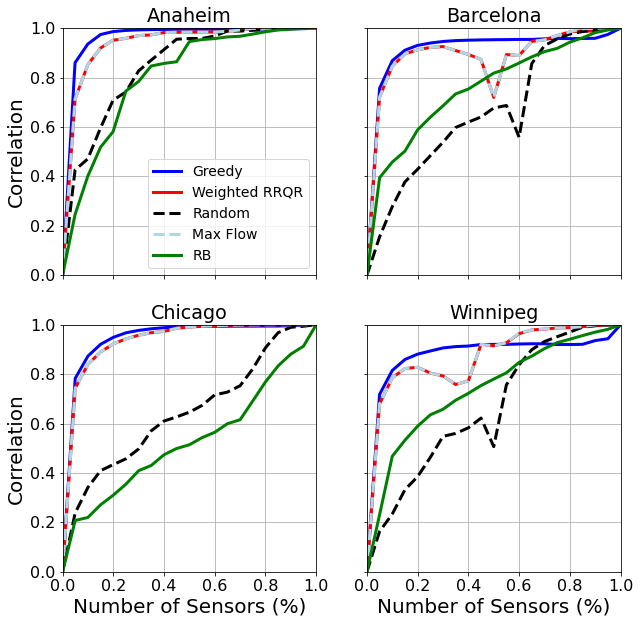

In [11]:
matplotlib.rcParams.update({'font.size': 16})

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
plot_results(results["Anaheim"], ax[0][0], "Anaheim", ylabel=True, legend=True)
plot_results(results["Barcelona"], ax[0][1], "Barcelona")
plot_results(results["Chicago"], ax[1][0], "Chicago", xlabel=True, ylabel=True)
plot_results(results["Winnipeg"], ax[1][1], "Winnipeg", xlabel=True)
plt.savefig("results/rrqr_maxflow_results.pdf")

## Power Flows

In [ ]:
def plot_spectral_coefs(G, flow, ax, title, xlabel=False, ylabel=False):
    n, m = G.number_of_nodes(), G.number_of_edges()

    B = nx.incidence_matrix(G, oriented=True).toarray()
    U, s, Vh = linalg.svd(B)
    Sigma = linalg.diagsvd(s, U.shape[1], Vh.shape[0])
    s = list(s) + [0] * (m - n)
    
    p = Vh @ utils.metrics.dict2vect(G, flow) 
    
    ax.scatter(range(G.number_of_edges(), 0, -1), (1 / np.linalg.norm(p)) * p)
    ax.axvline(x=G.number_of_edges() - G.number_of_nodes() + 1, c="black", linestyle="dashed")
    ax.set_title(title)
    if xlabel:
        ax.set_xlabel("Rank")
    if ylabel:
        ax.set_ylabel("Spectral Coefficient")
    
    return U, s, Vh.T

In [173]:
import pandas as pd

G = nx.from_pandas_edgelist(pd.read_csv("data/power_net.csv", header=None), source=0, target=1, create_using=nx.DiGraph)
with open("data/flows_power.pkl", "rb") as f:
    labeled_flows = pickle.load(f)

In [113]:
evaluator = flows.lazy.LazyEvaluator(G, labeled_flows)
results = evaluator.get_results()

100%|█████████████████████████████████████████████████████████████| 2729/2729 [01:32<00:00, 29.54it/s]
/home/ab141/.conda/envs/sensor/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
100%|█████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.60it/s]


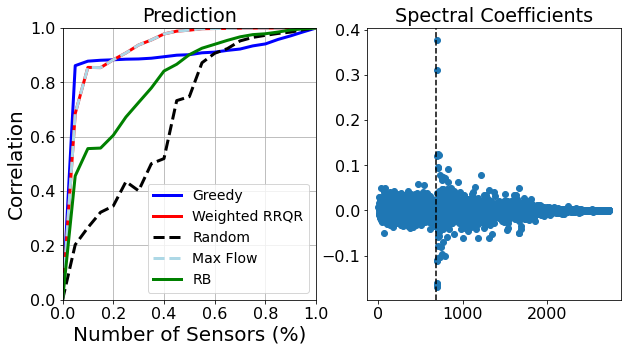

In [129]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plot_results(results, ax[0], "Prediction", legend=True, xlabel=True, ylabel=True)
_, _, _ = plot_spectral_coefs(G, labeled_flows, ax[1], "Spectral Coefficients")
plt.savefig("results/power_rrqr.pdf")

## Partially Known Flows

In [25]:
from tqdm.notebook import tqdm

class IterativeEvaluator(flows.lazy.LazyEvaluator):
    
    def al_flows_rrqr(self, ratio):
        k = int(ratio * len(self.labeled_edges))
        edges = list(self.G.edges())
        sensors = self.al_flows_rb(0.05)
        unchosen = list(range(self.G.number_of_edges()))
        
        U, s, Vh = linalg.svd(nx.incidence_matrix(self.G, oriented=True).todense())
        V = Vh.T
        
        V_C = linalg.null_space(nx.incidence_matrix(self.G, oriented=True).todense())
        
        while len(sensors) < k:
            # Make prediction based on current sensors
            f = utils.metrics.dict2vect(self.G, self.predict(sensors))[unchosen]
                        
            # Select next sensors using RRQR
            q, r, p = linalg.qr(V_C[np.ix_(unchosen)].T @ np.diag(f), pivoting=True)
            chosen = [unchosen[e] for e in p[:10]]
            
            # Add the sensors to list
            sensors += [edges[e] for e in chosen]
            for e in chosen:
                unchosen.remove(e)
        
        return sensors
    
    def al_flows_max(self, ratio):
        k = int(ratio * len(self.labeled_edges))
        sensors = []
        unchosen = list(self.G.edges())
        
        while len(sensors) < k:
            pred = self.predict(sensors)
            candidates = {e: pred[e] for e in unchosen}
            s = max(candidates, key=lambda e: abs(pred[e]))
            sensors.append(s)
            unchosen.remove(s)
        
        return sensors
    
    def get_results(self, samples=20):
        rand_sensors, rand_res = self.al_flows_random(1), {0: 0}  
        rb_sensors, rb_res = self.al_flows_rb(1), {0: 0}        
        max_sensors, max_res = self.al_flows_max(1), {0: 0}
        rrqr_sensors, rrqr_res = self.al_flows_rrqr(1), {0: 0}
                
        for i in tqdm(range(1, samples + 1)):
            k =  int(i * len(self.labeled_edges) / samples)
            rrqr_res[k / len(self.labeled_edges)] = self.get_pred_correlation(rrqr_sensors[:k])
            rand_res[k / len(self.labeled_edges)] = self.get_pred_correlation(rand_sensors[:k])
            max_res[k / len(self.labeled_edges)] = self.get_pred_correlation(max_sensors[:k]) 
            rb_res[k / len(self.labeled_edges)] = self.get_pred_correlation(rb_sensors[:k])
            
        return {
            "rrqr": rrqr_res,
            "random": rand_res,
            "rb": rb_res,
            "max": max_res
        }

In [27]:
results = {}
results["Anaheim"] = IterativeEvaluator(*utils.data.read_tntp_graph("data/Anaheim/Anaheim_flow.tntp")).get_results()
results["Barcelona"] = IterativeEvaluator(*utils.data.read_tntp_graph("data/Barcelona/Barcelona_flow.tntp")).get_results()
results["Chicago"] = IterativeEvaluator(*utils.data.read_tntp_graph("data/Chicago-Sketch/ChicagoSketch_flow.tntp")).get_results()
results["Winnipeg"] = IterativeEvaluator(*utils.data.read_tntp_graph("data/Winnipeg/Winnipeg_flow.tntp")).get_results()

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

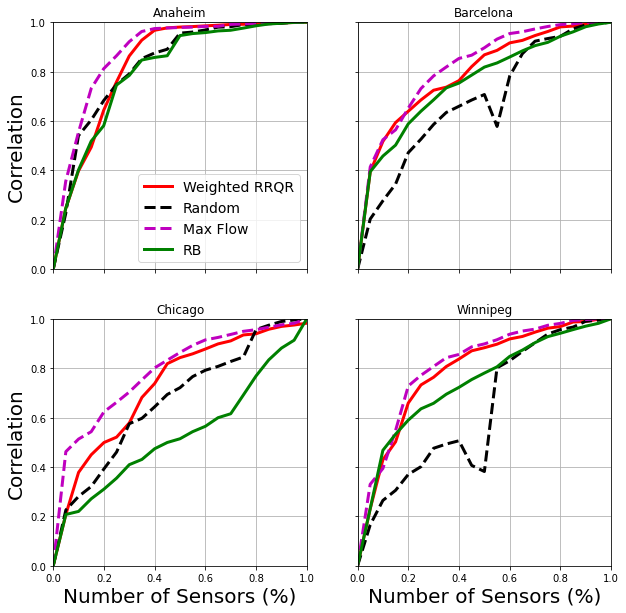

In [30]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
plot_results(results["Anaheim"], ax[0][0], "Anaheim", ylabel=True, legend=True)
plot_results(results["Barcelona"], ax[0][1], "Barcelona")
plot_results(results["Chicago"], ax[1][0], "Chicago", xlabel=True, ylabel=True)
plot_results(results["Winnipeg"], ax[1][1], "Winnipeg", xlabel=True)
# plt.savefig("results/iterative_rrqr_maxflow.pdf")

## Distribution of Flows

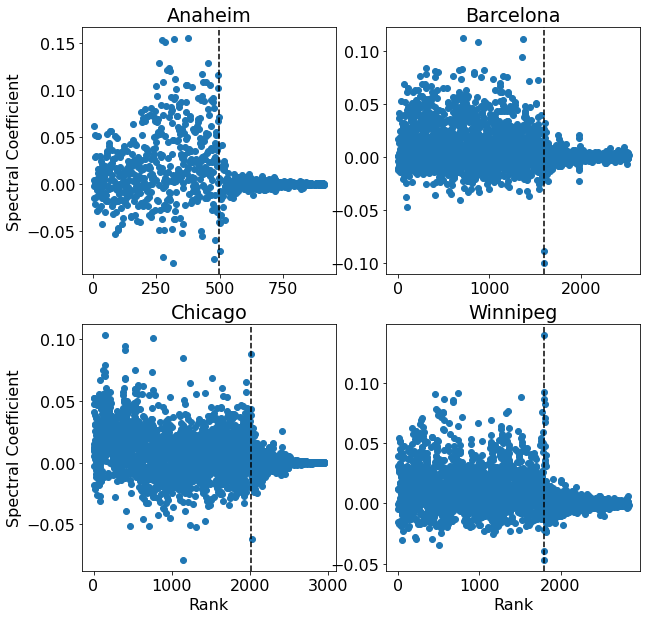

In [56]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

plot_spectral_coefs(*utils.data.read_tntp_graph("data/Anaheim/Anaheim_flow.tntp"), ax[0][0], "Anaheim", ylabel=True)
plot_spectral_coefs(*utils.data.read_tntp_graph("data/Barcelona/Barcelona_flow.tntp"), ax[0][1], "Barcelona")
plot_spectral_coefs(*utils.data.read_tntp_graph("data/Chicago-Sketch/ChicagoSketch_flow.tntp"), ax[1][0], "Chicago",
                   xlabel=True, ylabel=True)
_, _, _ = plot_spectral_coefs(*utils.data.read_tntp_graph("data/Winnipeg/Winnipeg_flow.tntp"), ax[1][1], "Winnipeg",
                             xlabel=True)
plt.savefig("results/spectral_coefs.pdf")

In [ ]:
def pred_scatterplot(G, labeled_flows, ax, title, xlabel=False, ylabel=False):
    f = utils.metrics.dict2vect(G, labeled_flows)
    f /= max(f)
    
    evaluator = IterativeEvaluator(G, utils.metrics.vect2dict(G, f))
    greedy_sensors = evaluator.al_flows_greedy(.1)
    max_sensors = evaluator.al_flows_max(.1)
    
    ax[0].scatter(f, utils.metrics.dict2vect(G, evaluator.predict(max_sensors)))
    ax[1].scatter(f, utils.metrics.dict2vect(G, evaluator.predict(greedy_sensors)))

## Some Theory

In [382]:
G, labeled_flows = utils.data.read_tntp_graph("data/Anaheim/Anaheim_flow.tntp")
evaluator = IterativeEvaluator(G, labeled_flows)

In [383]:
import json

with open("data/Anaheim/anaheim_nodes.geojson") as f:
    features = json.loads(f.read())["features"]

coords = {}
for feat in features:
    coords[feat["properties"]["id"]] = feat["geometry"]["coordinates"]

In [384]:
f = utils.metrics.dict2vect(G, labeled_flows)
B = nx.incidence_matrix(G, oriented=True)
V_R = linalg.orth(B.T.todense())
V_C = linalg.null_space(B.todense())
k = int(G.number_of_edges() / 10)

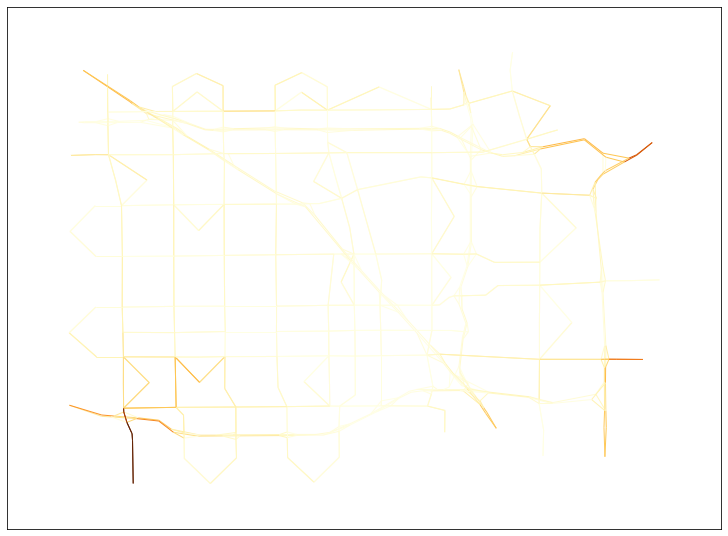

In [385]:
plt.figure(figsize=[2 * x for x in [6.4, 4.8]])
nx.draw_networkx_edges(G, coords, 
        edge_color=abs(V_R @ V_R.T @ f),
        arrows=False,
        edge_cmap=plt.cm.YlOrBr)

In [ ]:
rand_sensors = evaluator.al_flows_random(.1)
plt.figure(figsize=[2 * x for x in [6.4, 4.8]])
nx.draw_networkx_edges(G, coords, 
        edge_color=["red" if e in rand_sensors else "black" for e in G.edges()],
        width=np.log(utils.metrics.dict2vect(G, evaluator.predict(rand_sensors))),
        arrows=False)

/tmp/ipykernel_294335/1253033277.py:5: RuntimeWarning: divide by zero encountered in log
  width=np.log(utils.metrics.dict2vect(G, evaluator.predict(rand_sensors))),
/tmp/ipykernel_294335/1253033277.py:5: RuntimeWarning: invalid value encountered in log
  width=np.log(utils.metrics.dict2vect(G, evaluator.predict(rand_sensors))),
/home/ab141/.conda/envs/sensor/lib/python3.10/site-packages/matplotlib/lines.py:66: RuntimeWarning: invalid value encountered in double_scalars
  scaled_offset = offset * lw


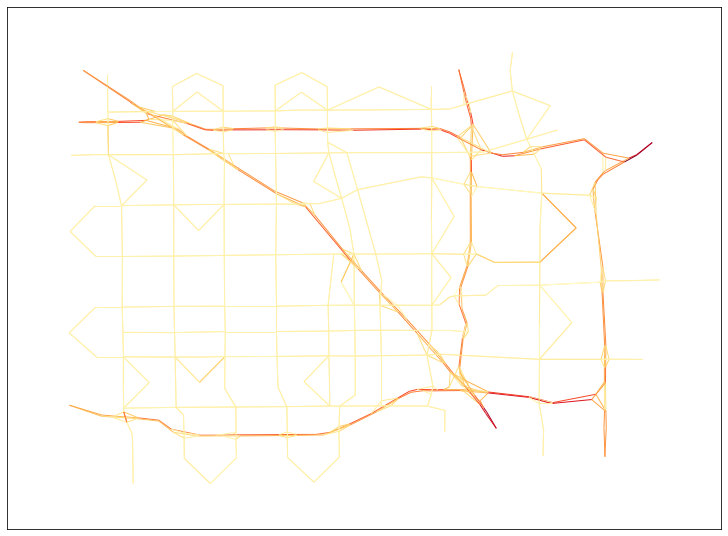

In [381]:
greedy_sensors = evaluator.al_flows_greedy(.1)
plt.figure(figsize=[2 * x for x in [6.4, 4.8]])
nx.draw_networkx_edges(G, coords, 
        edge_color=utils.metrics.dict2vect(G, evaluator.predict(greedy_sensors)),
        arrows=False,
        edge_cmap=plt.cm.YlOrRd)

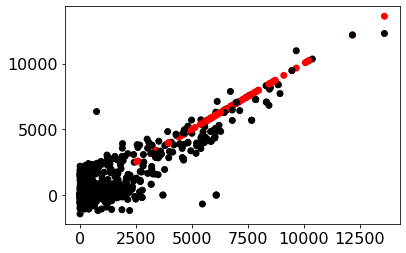

In [354]:
pred_max = utils.metrics.dict2vect(G, evaluator.predict(max_sensors))
pred_greedy = utils.metrics.dict2vect(G, evaluator.predict(greedy_sensors))
plt.scatter(f, pred_greedy, c=["red" if e in greedy_sensors else "black" for e in G.edges()])

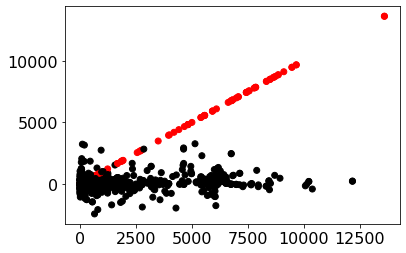

In [355]:
plt.scatter(f, pred_max, c=["red" if e in max_sensors else "black" for e in G.edges()])

### Chicago

In [364]:
G, labeled_flows = utils.data.read_tntp_graph("data/Chicago-Sketch/ChicagoSketch_flow.tntp")
evaluator = flows.lazy.LazyEvaluator(G, labeled_flows)

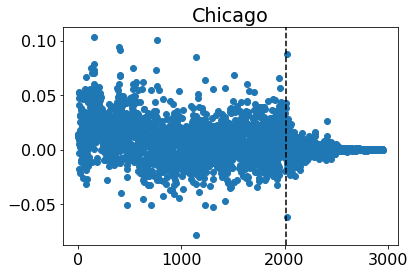

In [365]:
fig, ax = plt.subplots(1, 1)
U, s, V = plot_spectral_coefs(G, labeled_flows, ax, "Chicago")

In [366]:
f = utils.metrics.dict2vect(G, labeled_flows)
B = nx.incidence_matrix(G, oriented=True)
V_R = linalg.orth(B.T.todense())
V_C = linalg.null_space(B.todense())
c = G.number_of_edges() - G.number_of_nodes() + 1

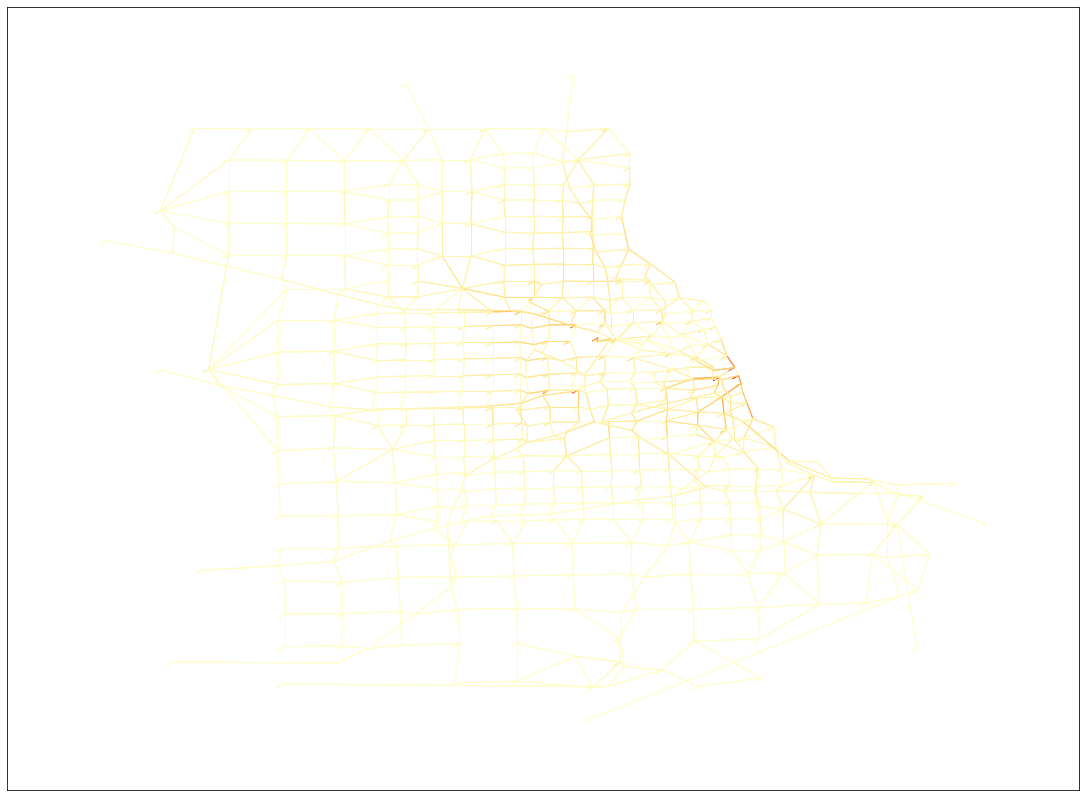

In [367]:
import pandas as pd

coords = pd.read_csv("data/Chicago-Sketch/ChicagoSketch_node.tntp", sep="\t")
coords = coords.set_index('node').to_dict(orient='index')

plt.figure(figsize=[3 * x for x in [6.4, 4.8]])
nx.draw_networkx_edges(G, pos={v: (coords[v]["X"], coords[v]["Y"]) for v in G.nodes()}, arrows=False,
                      edge_color=abs(V_R @ V_R.T @ f),
                      edge_cmap=plt.cm.YlOrRd)

In [ ]:
_, _, _ = plot_spectral_coefs(G, evaluator.predict(sensors[:int(k / 2)]))

In [8]:
G, labeled_flows, speeds = utils.data.read_traffic_data("small")
evaluator = flows.lazy.LazyEvaluator(G, labeled_flows)
pred = evaluator.predict(labeled_flows.keys())

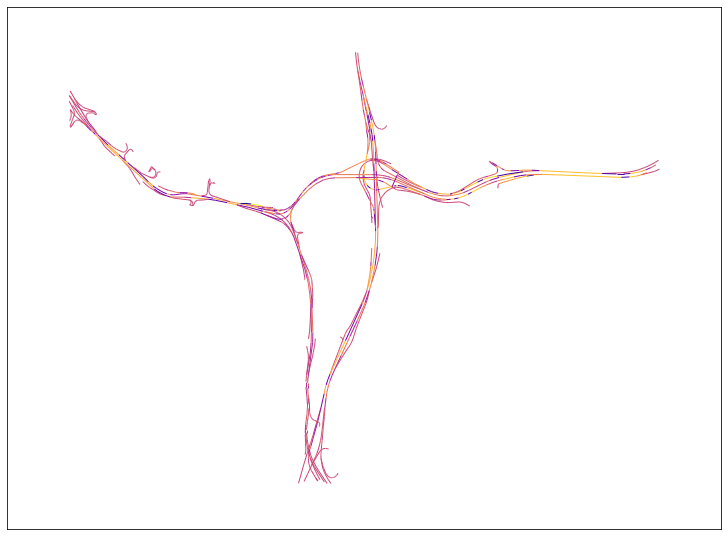

In [22]:
import matplotlib.pyplot as plt

with open("data/small_coords.pkl", "rb") as f:
    coords = {int(v): c for v, c in pickle.load(f).items()}
    
plt.figure(figsize=[2 * x for x in [6.4, 4.8]])
nx.draw_networkx_edges(G, coords,
                      edge_color=utils.metrics.dict2vect(G, pred),
                      edge_cmap=plt.cm.plasma)
plt.savefig("results/small_pred.pdf")